# Notebook to demo MAO (Multi Agent Orchestration)

In [1]:
import os
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
import os
import uuid
from textwrap import dedent

import shapely
from gait import MAO, Agent, ObserverLoguru, Scratchpad
from rich.pretty import pprint

In [3]:
model = f"azure/{os.environ['AZURE_API_DEPLOYMENT']}"

In [5]:
## Define the functions.

In [6]:
def buffer_geometry(
    geom_uuid: str,
    distance_in_meters: float,
    scratchpad: Scratchpad,
) -> str:
    """Buffer a geometry referenced by a UUID by a distance in meters.
    Return the buffered geometry UUID.

    :param geom_uuid: UUID of a geometry to buffer.
    :param distance_in_meters: The buffer distance in meters.
    :param scratchpad: Scratchpad instance injected at runtime.
    """
    geom = scratchpad[geom_uuid]
    buff = shapely.buffer(geom, distance_in_meters)
    buff_uuid = str(uuid.uuid4())
    scratchpad[buff_uuid] = buff
    return buff_uuid

In [7]:
def wkt_to_geometry(
    wkt: str,
    scratchpad: Scratchpad,
) -> str:
    """Parse WKT string into a geometry UUID. The following are WKT string samples: POINT (30 10) LINESTRING (30 10, 10 30, 40 40) POLYGON ((30 10, 40 40, 20 40, 10 20, 30 10))

    :param wkt: The well known text to convert to a geometry UUID.
    :param scratchpad:  Scratchpad instance injected at runtime.
    """
    geom = shapely.from_wkt(wkt, on_invalid="ignore")
    geom_uuid = str(uuid.uuid4())
    scratchpad[geom_uuid] = geom
    return geom_uuid

In [8]:
buffer_agent = Agent(
    model=model,
    name="BufferAgent",
    description="Buffer a geometry by a distance",
    functions=[buffer_geometry],
    temperature=0.0,
)

In [9]:
def send_to_buffer_agent():
    """Return a reference to an agent that will buffer a geometry."""
    return buffer_agent

In [10]:
wkt_to_geometry_agent = Agent(
    model=model,
    name="WKTAgent",
    description="Convert WKT string to geometry UUID",
    functions=[wkt_to_geometry],
    temperature=0.0,
)

In [11]:
def send_to_wkt_to_geometry_agent():
    """Return a reference to an agent that will parse WKT string into a geometry UUID."""
    return wkt_to_geometry_agent

In [12]:
instructions = dedent(
    """
Classify the user request and send it to the correct agent.
If the use request contains a geometry in WKT, make sure to first parse it before performing any operation.

The following are WKT string samples:
    POINT (30 10)
    LINESTRING (30 10, 10 30, 40 40)
    POLYGON ((30 10, 40 40, 20 40, 10 20, 30 10))

Make sure to send the request to one agent at the time if they are depending on each other.
"""
).strip()

In [13]:
classifier = Agent(
    model=model,
    name="Classifier",
    instructions=instructions,
    functions=[
        # send_to_buffer_agent,
        # send_to_wkt_to_geometry_agent,
        buffer_geometry,
        wkt_to_geometry,
    ],
    temperature=0.0,
)

In [14]:
geom_uuid = None

In [15]:
mao = MAO(
    agent=classifier,
    observer=ObserverLoguru(),
)

In [16]:
for _ in mao("Buffer by 20 meters POINT (10 30). Make sure to response with ONLY the geometry identifer."):
    if _.content:
        mao.terminate()
        geom_uuid = _.content

17:14:02 | INFO | Iteration 1 (Classifier) started.
17:14:03 | INFO | Content: None
17:14:03 | INFO | Function: wkt_to_geometry({"wkt":"POINT (10 30)"})
17:14:03 | INFO | Observation: 2b7abc07-8ea6-400a-a16b-4d9a7a18607e
17:14:03 | INFO | Iteration 2 (Classifier) started.
17:14:03 | INFO | Content: None
17:14:03 | INFO | Function: buffer_geometry({"geom_uuid":"2b7abc07-8ea6-400a-a16b-4d9a7a18607e","distance_in_meters":20})
17:14:03 | INFO | Observation: 4ff91dbf-9f33-4654-ad57-0ae10d8cce18
17:14:03 | INFO | Iteration 3 (Classifier) started.
17:14:04 | INFO | Content: 4ff91dbf-9f33-4654-ad57-0ae10d8cce18


In [17]:
for _ in mao.dialog:
    pprint(_, expand_all=True)

{
│   'role': 'user',
│   'content': 'Buffer by 20 meters POINT (10 30). Make sure to response with ONLY the geometry identifer.'
}

Message(
│   content=None,
│   role='assistant',
│   tool_calls=[
│   │   {
│   │   │   'function': {
│   │   │   │   'arguments': '{"wkt":"POINT (10 30)"}',
│   │   │   │   'name': 'wkt_to_geometry'
│   │   │   },
│   │   │   'id': 'call_Fqqe0jFI4vYHGwX0I6LwxV3Y',
│   │   │   'type': 'function'
│   │   }
│   ],
│   function_call=None,
│   provider_specific_fields={
│   │   'refusal': None
│   },
│   annotations=[]
)

{
│   'role': 'tool',
│   'content': '2b7abc07-8ea6-400a-a16b-4d9a7a18607e',
│   'name': 'wkt_to_geometry',
│   'tool_call_id': 'call_Fqqe0jFI4vYHGwX0I6LwxV3Y'
}

Message(
│   content=None,
│   role='assistant',
│   tool_calls=[
│   │   {
│   │   │   'function': {
│   │   │   │   'arguments': '{"geom_uuid":"2b7abc07-8ea6-400a-a16b-4d9a7a18607e","distance_in_meters":20}',
│   │   │   │   'name': 'buffer_geometry'
│   │   │   },
│   │   │   'id': 'call_6kA2hDFNcq2og2wuAkAJNy4B',
│   │   │   'type': 'function'
│   │   }
│   ],
│   function_call=None,
│   provider_specific_fields={
│   │   'refusal': None
│   },
│   annotations=[]
)

{
│   'role': 'tool',
│   'content': '4ff91dbf-9f33-4654-ad57-0ae10d8cce18',
│   'name': 'buffer_geometry',
│   'tool_call_id': 'call_6kA2hDFNcq2og2wuAkAJNy4B'
}

Message(
│   content='4ff91dbf-9f33-4654-ad57-0ae10d8cce18',
│   role='assistant',
│   tool_calls=None,
│   function_call=None,
│   provider_specific_fields={
│   │   'refusal': None
│   },
│   annotations=[]
)

In [18]:
for _ in mao.scratchpad:
    pprint(_, expand_all=True)

(
│   '2b7abc07-8ea6-400a-a16b-4d9a7a18607e',
│   <POINT (10 30)>
)

(
│   '4ff91dbf-9f33-4654-ad57-0ae10d8cce18',
│   <POLYGON ((30 30, 29.616 26.098, 28.478 22.346, 26.629 18.889, 24.142 15.858...>
)

## View the geometry.

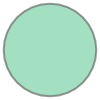

In [19]:
mao.scratchpad[geom_uuid]